In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-04-04 20:44:02.062701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 20:44:02.062815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 20:44:02.192085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = 224
IMG_PATH = "/kaggle/input/flickr8k/Images/"

In [3]:
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [4]:
def load_image(img):
    img = load_img(img, color_mode='rgb',target_size=(IMG_SIZE,IMG_SIZE))
    img = img_to_array(img)
    img = img/255.
    return img

def plot_images_with_captions(df):
    df = df.reset_index(drop=True)
    plt.figure(figsize = (20,20))
    pos = 1
    rows = len(df.index)
    for i in range(len(df.index)):
        plt.subplot(5,5, pos)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        pos += 1
        #print(df.image[i])
        image = load_image(f"../input/flickr8k/Images/{df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(df.caption[i], 20)))
        plt.axis("off")
    

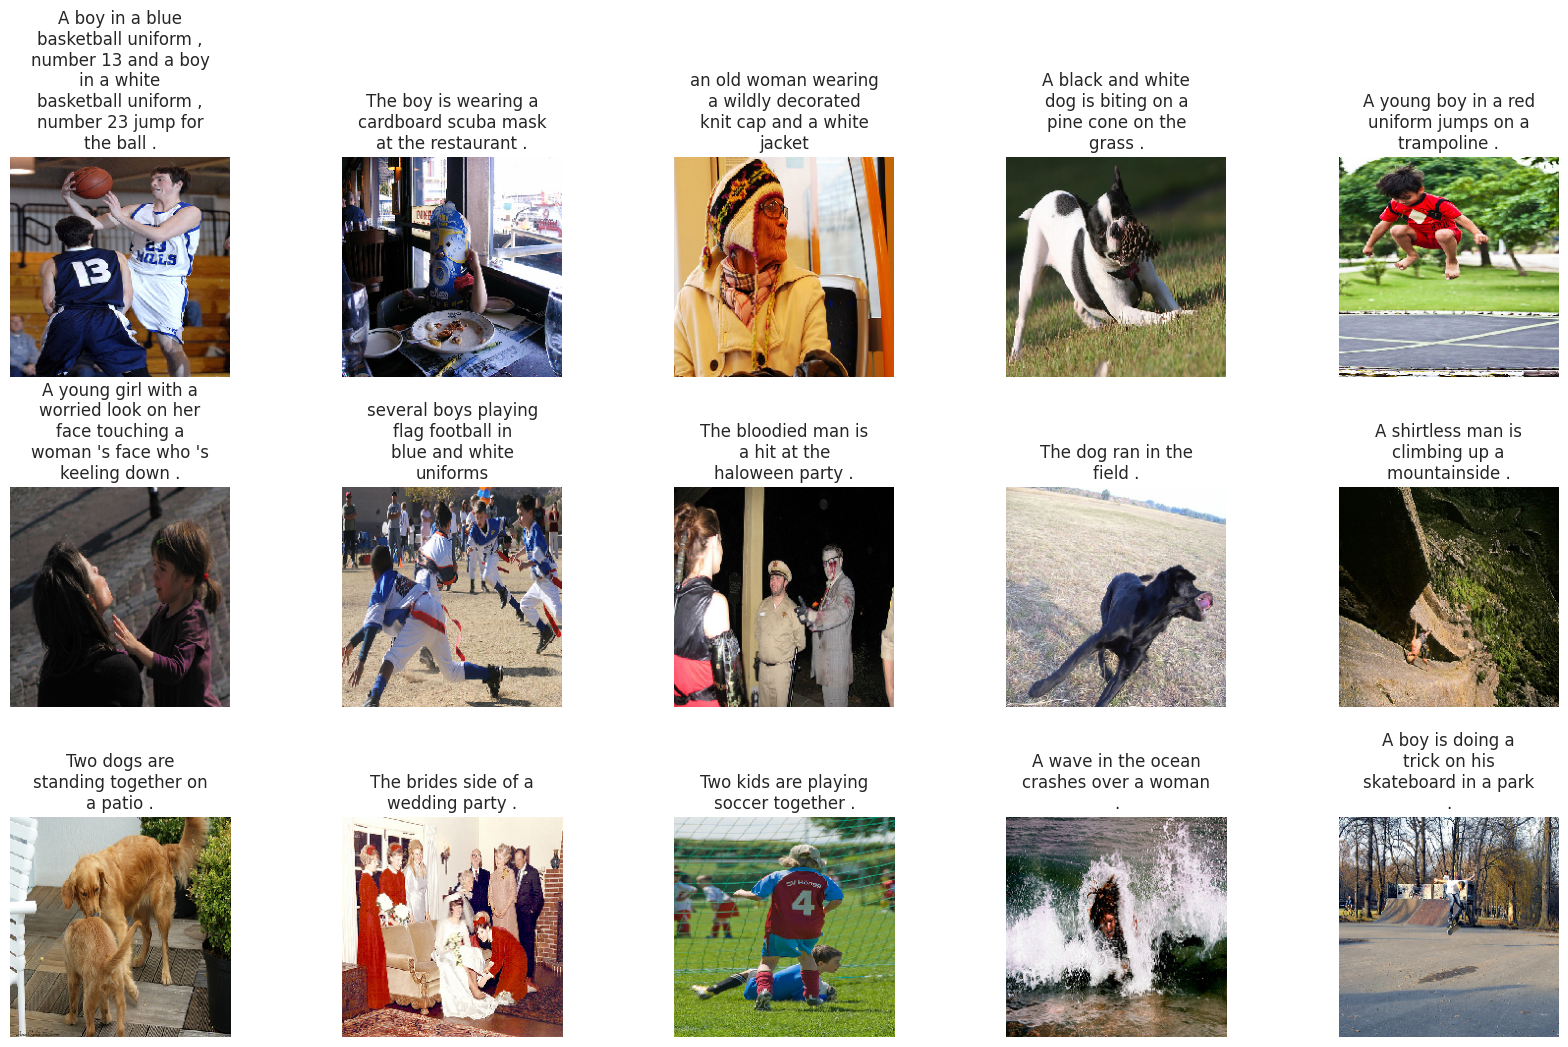

In [5]:
plot_images_with_captions(data.sample(15))

In [6]:
data['caption'].head()

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
Name: caption, dtype: object

In [7]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x: x.lower())
    df['caption'] = df['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    df['caption'] = df['caption'].apply(lambda x: x.replace("\s+"," "))
    df['caption'] = df['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    df['caption'] = "startseq "+df['caption']+" endseq"
    return df

In [8]:
data = text_preprocessing(data)
captions = data['caption']
captions.head()

0    startseq child in pink dress is climbing up se...
1      startseq girl going into wooden building endseq
2    startseq little girl climbing into wooden play...
3    startseq little girl climbing the stairs to he...
4    startseq little girl in pink dress going into ...
Name: caption, dtype: object

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
sequences = tokenizer.texts_to_sequences(captions)
sequences[0]

[1, 42, 3, 89, 171, 6, 118, 50, 392, 11, 393, 3, 27, 5145, 669, 2]

In [10]:
images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [12]:
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.models import Sequential, Model
from tqdm import tqdm

In [13]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

features  = {}
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_image(f"../input/flickr8k/Images/{image}")
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1712263495.761849      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [13:24<00:00, 10.06it/s]


In [14]:
def print_features(features, n):
    i =0
    for k,v in features.items():
        i += 1
        if i>=n:
            break
        else:
            print(features[k])
print_features(features, 5)

[[7.8687910e-05 7.3524052e-04 1.1395991e-03 ... 5.6523514e-01
  2.2903769e-01 6.9639754e-01]]
[[1.2493602e-04 4.5205693e-04 1.9292444e-03 ... 7.4857235e-02
  2.0473912e+00 9.0312667e-02]]
[[5.0413935e-05 3.7102986e-04 1.9412235e-03 ... 8.7596484e-02
  4.6891645e-01 3.1746235e-01]]
[[1.4095563e-04 7.7881786e-04 1.2702048e-03 ... 2.2357763e-01
  8.1238255e-02 1.3331111e-01]]


In [15]:
feature.shape

(1, 1920)

In [16]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [17]:
vocab_size = len(tokenizer.word_index) + 1

input1 = Input(shape=(1920,)) # feature
input2 = Input(shape=(max_length,)) # tokenized captions

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [18]:
from tensorflow.keras.utils import plot_model

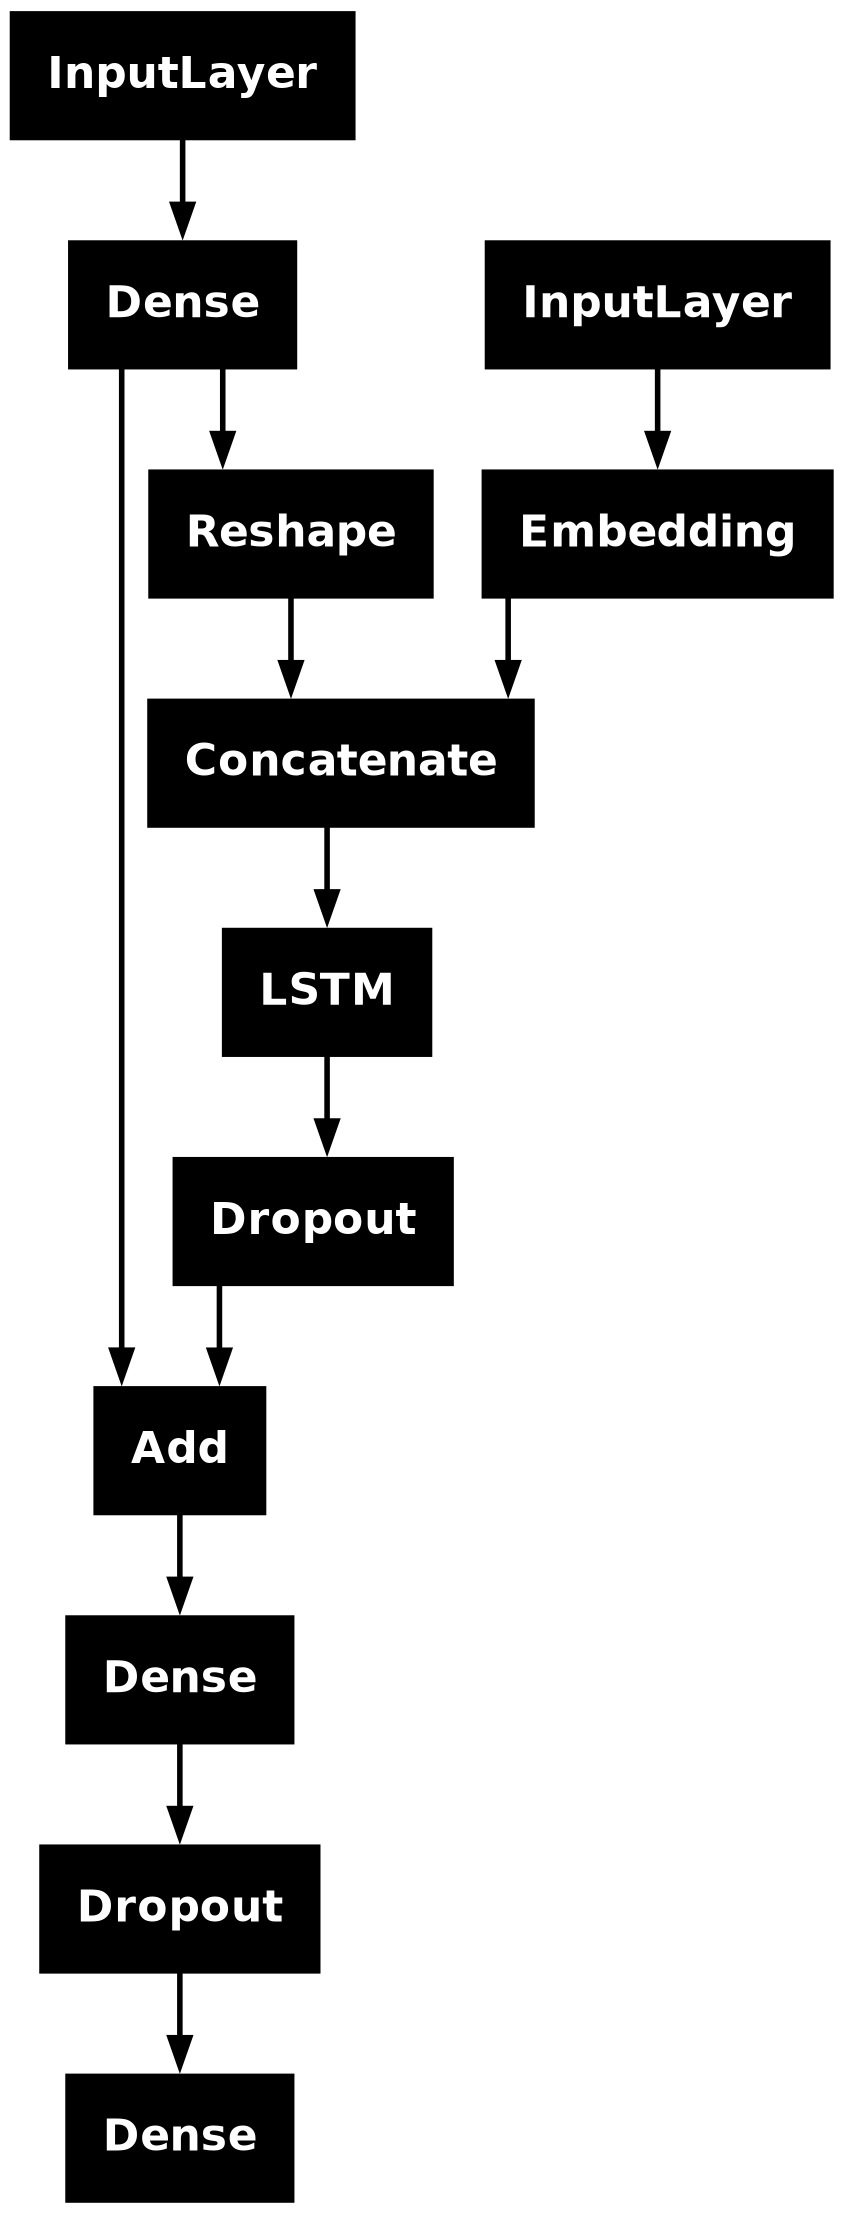

In [19]:
plot_model(caption_model)

In [20]:
caption_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 36, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=IMG_PATH,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=IMG_PATH,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)






In [22]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [23]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 5.6600
Epoch 1: val_loss improved from inf to 4.19781, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 323s 587ms/step - loss: 5.6588 - val_loss: 4.1978 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 4.2080
Epoch 2: val_loss improved from 4.19781 to 3.90757, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - loss: 4.2078 - val_loss: 3.9076 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 3.9389
Epoch 3: val_loss improved from 3.90757 to 3.78394, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 84s 154ms/step - loss: 3.9388 - val_loss: 3.7839 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.7739
Epoch 4: val_loss improved from 3.78394 to 3.72133, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - loss: 3.7738 - val_loss: 3.7213 - learning_rate: 0.0010

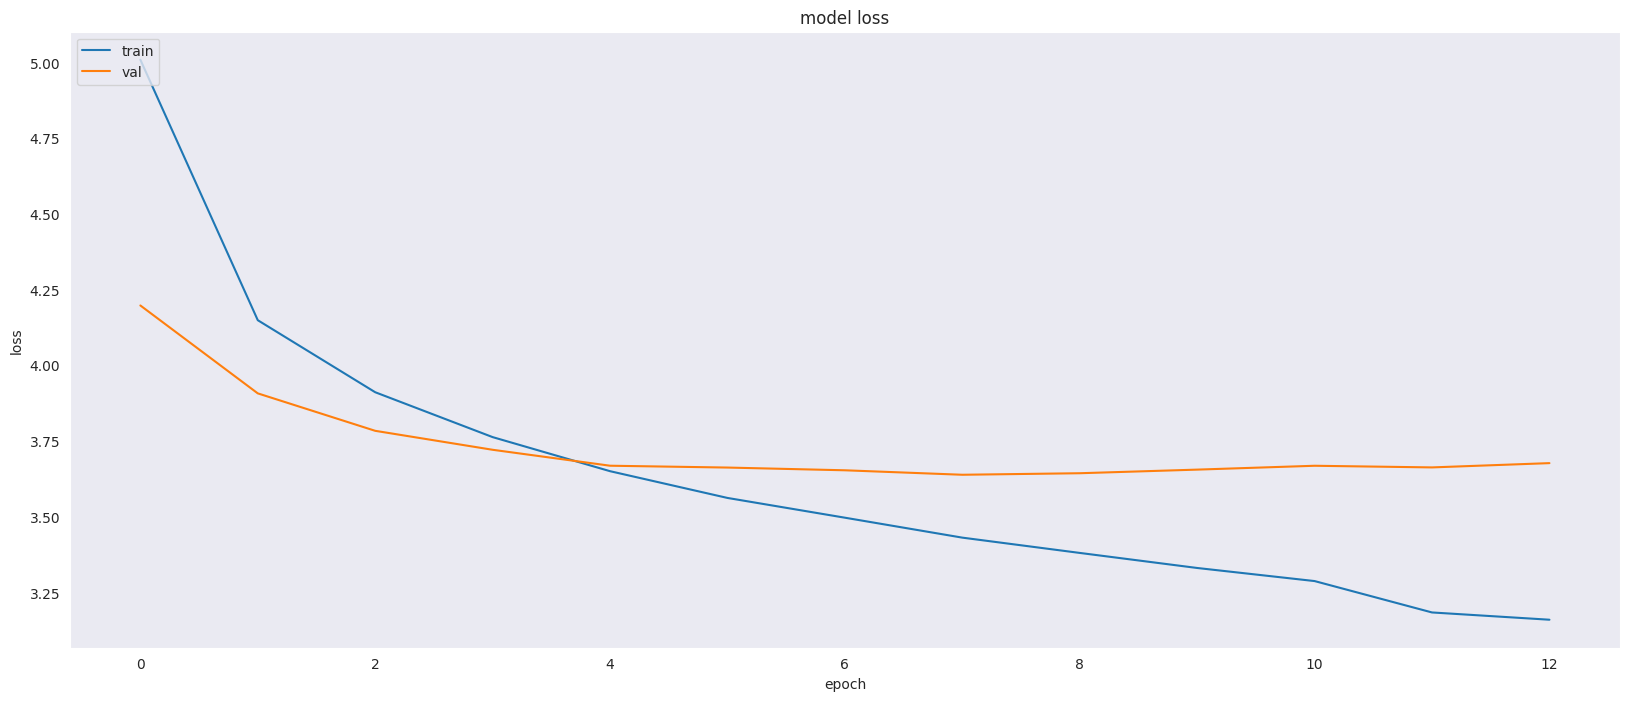

In [24]:

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [27]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [28]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(IMG_PATH,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption.replace('startseq','').replace('endseq','')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

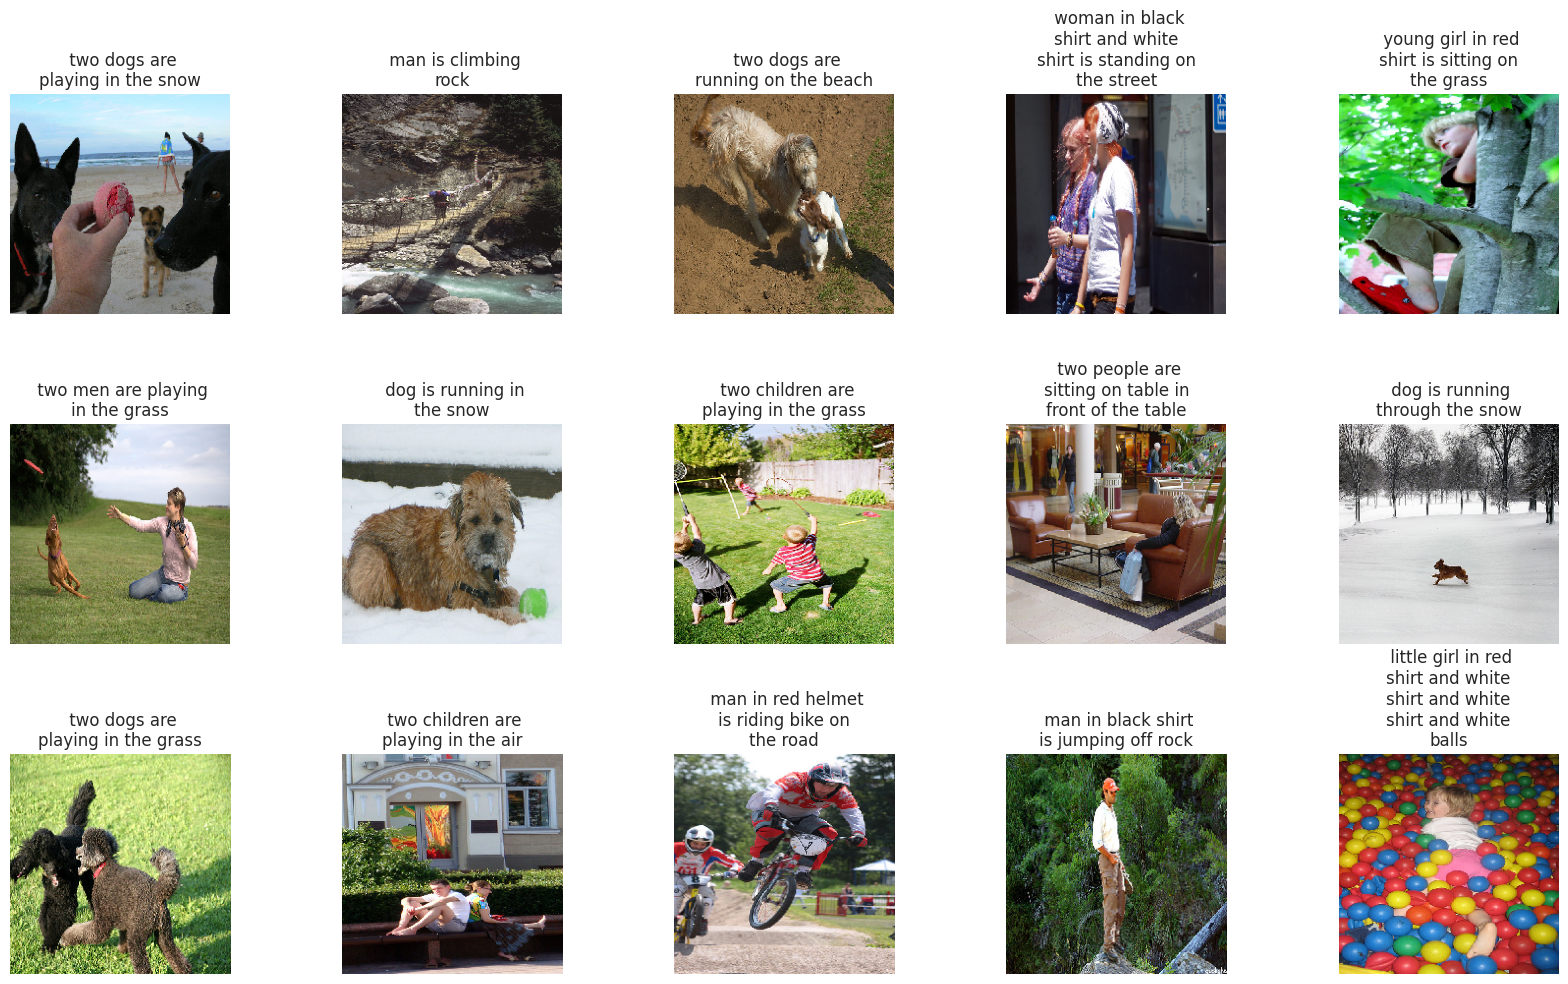

In [29]:
plot_images_with_captions(samples)